# Setup

In [1]:
!curl https://course.fast.ai/setup/colab | bash
from fastai.tabular import *

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9127    0  9127    0     0  10466      0 --:--:-- --:--:-- --:--:-- 10454
bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Setting directories

In [3]:
root_dir = "drive/My Drive/"
base_dir = root_dir + 'fastai-2019/'

In [4]:
print(base_dir)

drive/My Drive/fastai-2019/


# Loading cleaned data set

In [5]:
path = Path(base_dir + '/data/rossmann/rossmann_cleaned')
train_df = pd.read_pickle(path/'train_clean')

In [6]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,...,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,True,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,0,0,0,0,0,0,0,0,5.0,7.0,5.0,7.0,7.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,True,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950,25,0,0,0,0,0,0,5.0,7.0,5.0,1.0,1.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,True,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579,25,0,0,0,0,0,0,5.0,7.0,5.0,5.0,7.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,True,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9,2009,0,1,1900,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin,2009-09-15,2145,24,1900-01-01,0,0,0,0,0,0,0,0,5.0,7.0,5.0,1.0,1.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,True,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4,2015,0,1,1900,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015-04-15,107,3,1900-01-01,0,0,0,0,0,0,0,0,5.0,7.0,5.0,1.0,1.0,1.0


In [7]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,7,7,7,7,7
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,7,1,7,1,1


In [8]:
n = len(train_df)
n

844338

#Prepping data for tabular model

In [9]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [10]:
len(train_df),len(test_df)

(844338, 41088)

Using processors for data augmentation

In [11]:
procs=[FillMissing, Categorify, Normalize]

Defining categorical and continuous variables

In [12]:
categorical_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

continuous_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

dependent variable =  Sales

In [14]:
dependent_var = 'Sales'
df = train_df[categorical_vars + continuous_vars + [dependent_var,'Date']].copy()

In [15]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [16]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [17]:
valid_idx = range(cut)

In [18]:
df[dependent_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

**REMINDER**: Don't forget to indicate **float** in order to use Regression

In [37]:
data = (TabularList.from_df(df, path=path, cat_names=categorical_vars, cont_names=continuous_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dependent_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=categorical_vars, cont_names=continuous_vars))
                .databunch())

## Tabular model

In [38]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

**TIP:** You can add dropout to the embeddings. **Tabular models often use simpler neural networks**

In [39]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [40]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(2, 2)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(2, 2)
    (19): Embedding(8, 5)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [41]:
len(data.train_ds.cont_names)

16

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


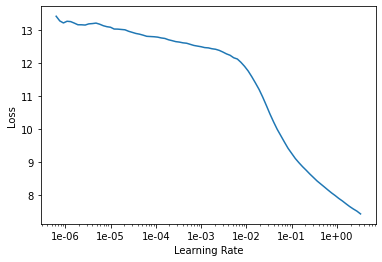

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(7, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.027047,0.035032,0.194776,04:09
1,0.022746,0.024508,0.168016,04:10
2,0.018140,0.017231,0.135396,04:11
3,0.018579,0.017622,0.137133,04:12
4,0.012842,0.016673,0.118152,04:09
5,0.010983,0.012240,0.106536,04:08
6,0.010588,0.011436,0.103456,04:06


In [46]:
learn.save('rossmann-1')

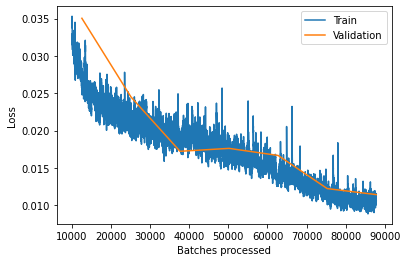

In [48]:
learn.recorder.plot_losses(skip_start=10000)

In [ ]:
# learn.load('rossman-1');

In [ ]:
# learn.fit_one_cycle(5, 3e-4)

In [ ]:
# learn.fit_one_cycle(5, 3e-4)

In [49]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann1_submission.csv",index=False)